In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

2023-11-12 18:06:08.478442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#feature indicating time between date_calc and date_forecast
X_train_raw["calc_time"] =(X_train_raw["date_forecast"] - X_train_raw["date_calc"]).astype('timedelta64[s]')

#fill nans
X_train_raw["snow_density:kgm3"] = X_train_raw["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})
X_train_raw["ceiling_height_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)
X_train_raw["cloud_base_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)

#create seperate dataframes for measurments at minute 00, 15, 30 and 45
X_train00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].reset_index().iloc[:,1:]
X_train15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].reset_index().iloc[:,1:]
X_train30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].reset_index().iloc[:,1:]
X_train45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].reset_index().iloc[:,1:]

#remove redundant data
X_train15 = X_train15.iloc[:,2:-2]
X_train30 = X_train30.iloc[:,2:-2]
X_train45 = X_train45.iloc[:,2:-2]

#join observations into single sample
X_train = X_train00.join(X_train15, lsuffix="_00", rsuffix="_15").join(X_train30.join(X_train45, lsuffix="_30", rsuffix="_45"))

#rename column for merging with targets
X_train = X_train.rename(columns={"date_forecast" : "time"})

#concat target values and drop NaN values
targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#merge weatherfeatures with corresponding target pv measurement
dataset = pd.merge(X_train, targets, how="inner", on=["time", "location"])

#shuffle dataset
dataset = dataset.sample(frac=1, random_state=43).reset_index().iloc[:,1:]

#split into features and targets
datasetX = dataset.iloc[:, :-1]
datasetY = dataset.iloc[:, -1:]

#add day_of_year and hour feature columns
datasetX["day"] = datasetX["time"].dt.day_of_year
datasetX["hour"] = datasetX["time"].dt.hour

#get indexes of samples in the months of the test dataset
indexMayJuneJuly = datasetX["time"].apply(lambda time : time.month in [5, 6, 7])

#OHE encoding for catagorical feature "location"
datasetX["location_A"] = datasetX["location"].apply(lambda a : a == "A").map({True: 1, False: 0})
datasetX["location_B"] = datasetX["location"].apply(lambda a : a == "B").map({True: 1, False: 0})
datasetX["location_C"] = datasetX["location"].apply(lambda a : a == "C").map({True: 1, False: 0})

datasetX = datasetX.drop("location", axis=1)

#move datecalc column
#date_calc_column = datasetX.pop("date_calc")
#datasetX.insert(183, "is_not_calculated", date_calc_column) #!constant 183 can be source of bugs

#fix nans for some reason???
#datasetX["is_not_calculated"] = datasetX["is_not_calculated"].fillna(method="ffill")

#map location labels to numbers
#datasetX["location"] = datasetX["location"].map({"A": 0, "B": 1, "C": 2})

#drop time and date_calc columns
datasetX = datasetX.iloc[:,2:]

#calculate mean and std for normalizing data, values should also be used for normalizing test data
dataMean = datasetX.mean()
dataStd = datasetX.std()

#normalize data
datasetX.iloc[:,:-4] = ((datasetX.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)


#partition into training and evalset
trainsetX = datasetX.iloc[:,:]
trainsetY = datasetY.iloc[:,:]
trainsetIndexMayJuneJuly = indexMayJuneJuly[:]
evalsetX = datasetX.iloc[85000:,:]
evalsetY = datasetY.iloc[85000:,:]
evalsetIndexMayJuneJuly = indexMayJuneJuly[85000:]


/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_15956/1911771154.py:125: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  datasetX.iloc[:,:-4] = ((datasetX.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)


In [3]:
is_estimated = trainsetX["calc_time"].apply(lambda a : a != trainsetX["calc_time"].min())

In [4]:
tf.keras.utils.set_random_seed(81)#Our group number as the seed to make the results reproducible

numModels = 20

models = []

i = 0
while(i < numModels):
  if(i < 10):
    models.append(tf.keras.models.Sequential([
          tf.keras.layers.Dense(100, activation="tanh"),
          tf.keras.layers.Dense(100, activation="relu"),
          tf.keras.layers.Dense(1, activation="relu"),
      ]))
  else:
    models.append(tf.keras.models.Sequential([
          tf.keras.layers.Dense(150, activation="tanh"),
          tf.keras.layers.Dense(120, activation="relu"),
          tf.keras.layers.Dense(90, activation="relu"),
          tf.keras.layers.Dense(60, activation="relu"),
          tf.keras.layers.Dense(1, activation="relu"),
      ]))
  models[i].compile(
      optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1
                                                          ),
      loss="mean_absolute_error"
  )

  history = models[i].fit(x = trainsetX.sample(frac=0.5 if i < 10 else 1, random_state=i),
                      y= trainsetY.sample(frac=0.5 if i < 10 else 1, random_state=i),
                      batch_size = 1000,
                      epochs=20,
                      verbose=0,
                      sample_weight=is_estimated.map({True: 3, False: 1}).sample(frac=0.5 if i < 10 else 1, random_state=i)
                  )

  #retry if model is nonsensical
  loss = models[i].evaluate(evalsetX, evalsetY)
  if(loss > 200):
      del models[i]
      continue

  print(i, " complete")
  i+=1


119/119 [==============================] - 1s 3ms/step - loss: 82.0870
0  complete
119/119 [==============================] - 0s 2ms/step - loss: 83.8275
1  complete
119/119 [==============================] - 0s 2ms/step - loss: 81.8912
2  complete
119/119 [==============================] - 0s 2ms/step - loss: 83.5289
3  complete
119/119 [==============================] - 0s 2ms/step - loss: 81.2820
4  complete
119/119 [==============================] - 0s 2ms/step - loss: 81.1929
5  complete
119/119 [==============================] - 0s 2ms/step - loss: 83.5843
6  complete
119/119 [==============================] - 0s 3ms/step - loss: 81.5443
7  complete
119/119 [==============================] - 0s 2ms/step - loss: 81.1767
8  complete
119/119 [==============================] - 0s 2ms/step - loss: 80.1743
9  complete
119/119 [==============================] - 1s 4ms/step - loss: 72.9752
10  complete
119/119 [==============================] - 0s 2ms/step - loss: 73.1915
11  complete
11

In [5]:
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

X_test_raw = pd.concat([
                     X_test_estimated_a,
                     X_test_estimated_b,
                     X_test_estimated_c])

#feature indicating time between date_calc and date_forecast
X_test_raw["calc_time"] =(X_test_raw["date_forecast"] - X_test_raw["date_calc"]).astype('timedelta64[s]')

#fill nans
X_test_raw["snow_density:kgm3"] = X_test_raw["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})
X_test_raw["ceiling_height_agl:m"] = X_test_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)
X_test_raw["cloud_base_agl:m"] = X_test_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)

#create seperate dataframes for measurments at minute 00, 15, 30 and 45
X_test00 = X_test_raw[X_test_raw["date_forecast"].apply(lambda time: time.minute == 0)].reset_index().iloc[:,1:]
X_test15 = X_test_raw[X_test_raw["date_forecast"].apply(lambda time: time.minute == 15)].reset_index().iloc[:,1:]
X_test30 = X_test_raw[X_test_raw["date_forecast"].apply(lambda time: time.minute == 30)].reset_index().iloc[:,1:]
X_test45 = X_test_raw[X_test_raw["date_forecast"].apply(lambda time: time.minute == 45)].reset_index().iloc[:,1:]

#remove redundant data
X_test15 = X_test15.iloc[:,2:-2]
X_test30 = X_test30.iloc[:,2:-2]
X_test45 = X_test45.iloc[:,2:-2]

#join observations into single sample
X_test_estimated = X_test00.join(X_test15, lsuffix="_00", rsuffix="_15").join(X_test30.join(X_test45, lsuffix="_30", rsuffix="_45"))


X_test_estimated = X_test_estimated.rename(columns={"date_forecast" : "time"})

parse_dates = ['time']
X_test_targets = pd.read_csv("test.csv", parse_dates=parse_dates)

X_test = pd.merge(X_test_estimated, X_test_targets, on=["time", "location"], how="right").iloc[:,:-2]


X_test["day"] = X_test["time"].dt.day_of_year
X_test["hour"] = X_test["time"].dt.hour

X_test["location_A"] = X_test["location"].apply(lambda a : a == "A").map({True: 1, False: 0})
X_test["location_B"] = X_test["location"].apply(lambda a : a == "B").map({True: 1, False: 0})
X_test["location_C"] = X_test["location"].apply(lambda a : a == "C").map({True: 1, False: 0})

X_test = X_test.drop("location", axis=1)

X_test = X_test.iloc[:,2:]


X_test.iloc[:,:-4] = ((X_test.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)





/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_15956/1501482422.py:63: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  X_test.iloc[:,:-4] = ((X_test.iloc[:,:-4]-dataMean[:-4])/dataStd[:-4]).fillna(value=0)


In [6]:
def models_predict(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)

    preds = preds.iloc[:,1:]
    preds["final"] = preds.mean(axis=1)
    return preds["final"]

In [7]:
test_preds = pd.read_csv("sample_submission.csv")
test_preds["prediction"] = models_predict(models, X_test)
display(test_preds)

68/68 [==============================] - 0s 2ms/step


id  prediction
0        0    0.000000
1        1    0.000000
2        2    0.000000
3        3   41.340107
4        4  375.183533
...    ...         ...
2155  2155   47.064247
2156  2156   22.575129
2157  2157    0.454200
2158  2158    0.000000
2159  2159    0.192511

[2160 rows x 2 columns]

In [8]:
X_test["prediction"] = test_preds["prediction"]
display(X_test)

absolute_humidity_2m:gm3_00  air_density_2m:kgm3_00  \
0                       -0.581187                0.822366   
1                       -0.618246                0.849555   
2                       -0.655304                0.767986   
3                       -0.692363                0.713602   
4                       -0.766481                0.713602   
...                           ...                     ...   
2155                     0.864104               -1.624782   
2156                     0.938221               -1.543210   
2157                     1.049398               -1.461638   
2158                     1.123515               -1.352877   
2159                     1.123515               -1.325686   

      ceiling_height_agl:m_00  clear_sky_energy_1h:J_00  clear_sky_rad:W_00  \
0                   -0.382900                 -0.619627           -0.618049   
1                   -1.085710                 -0.619627           -0.618049   
2                   -0.173677                 -0.619627           -0.618049   
3                    0.129317                 -0.619627           -0.618049   
4                    0.135379                 -0.546506           -0.429154   
...                       ...                       ...                 ...   
2155                 0.579692                  0.133114           -0.103201   
2156                 0.541699                 -0.289848           -0.442333   
2157                 0.198506                 -0.531551           -0.596523   
2158                 0.015666                 -0.617941           -0.618049   
2159                 0.018679                 -0.619627           -0.618049   

      cloud_base_agl:m_00  dew_or_rime:idx_00  dew_point_2m:K_00  \
0               -0.382900           -0.026723          -0.499357   
1               -1.085710           -0.026723          -0.513980   
2               -0.173677           -0.026723          -0.572466   
3                0.129317           -0.026723          -0.630958   
4                0.135379           -0.026723          -0.704067   
...                   ...                 ...                ...   
2155             0.579692           -0.026723           0.948210   
2156             0.541699           -0.026723           0.992074   
2157             0.198506           -0.026723           1.035942   
2158             0.015666           -0.026723           1.094429   
2159             0.018679           -0.026723           1.079806   

      diffuse_rad:W_00  diffuse_rad_1h:J_00  direct_rad:W_00  \
0            -0.644227            -0.651409        -0.440973   
1            -0.644227            -0.651409        -0.440973   
2            -0.644227            -0.651409        -0.440973   
3            -0.644227            -0.651409        -0.440973   
4            -0.124352            -0.388337        -0.343506   
...                ...                  ...              ...   
2155          0.039558             0.275186        -0.297430   
2156         -0.318063            -0.140474        -0.388695   
2157         -0.561444            -0.444488        -0.440973   
2158         -0.644227            -0.609705        -0.440973   
2159         -0.644227            -0.651409        -0.440973   

      direct_rad_1h:J_00  effective_cloud_cover:p_00  elevation:m_00  \
0              -0.446313                    0.393971       -0.700896   
1              -0.446313                   -0.067391       -0.700896   
2              -0.446313                    0.784135       -0.700896   
3              -0.446313                    0.231640       -0.700896   
4              -0.397041                   -0.235418       -0.700896   
...                  ...                         ...             ...   
2155           -0.303928                    0.647435        1.549095   
2156           -0.346992                    0.499344        1.549095   
2157           -0.419715                    0.055069        1.549095   
2158           -0.

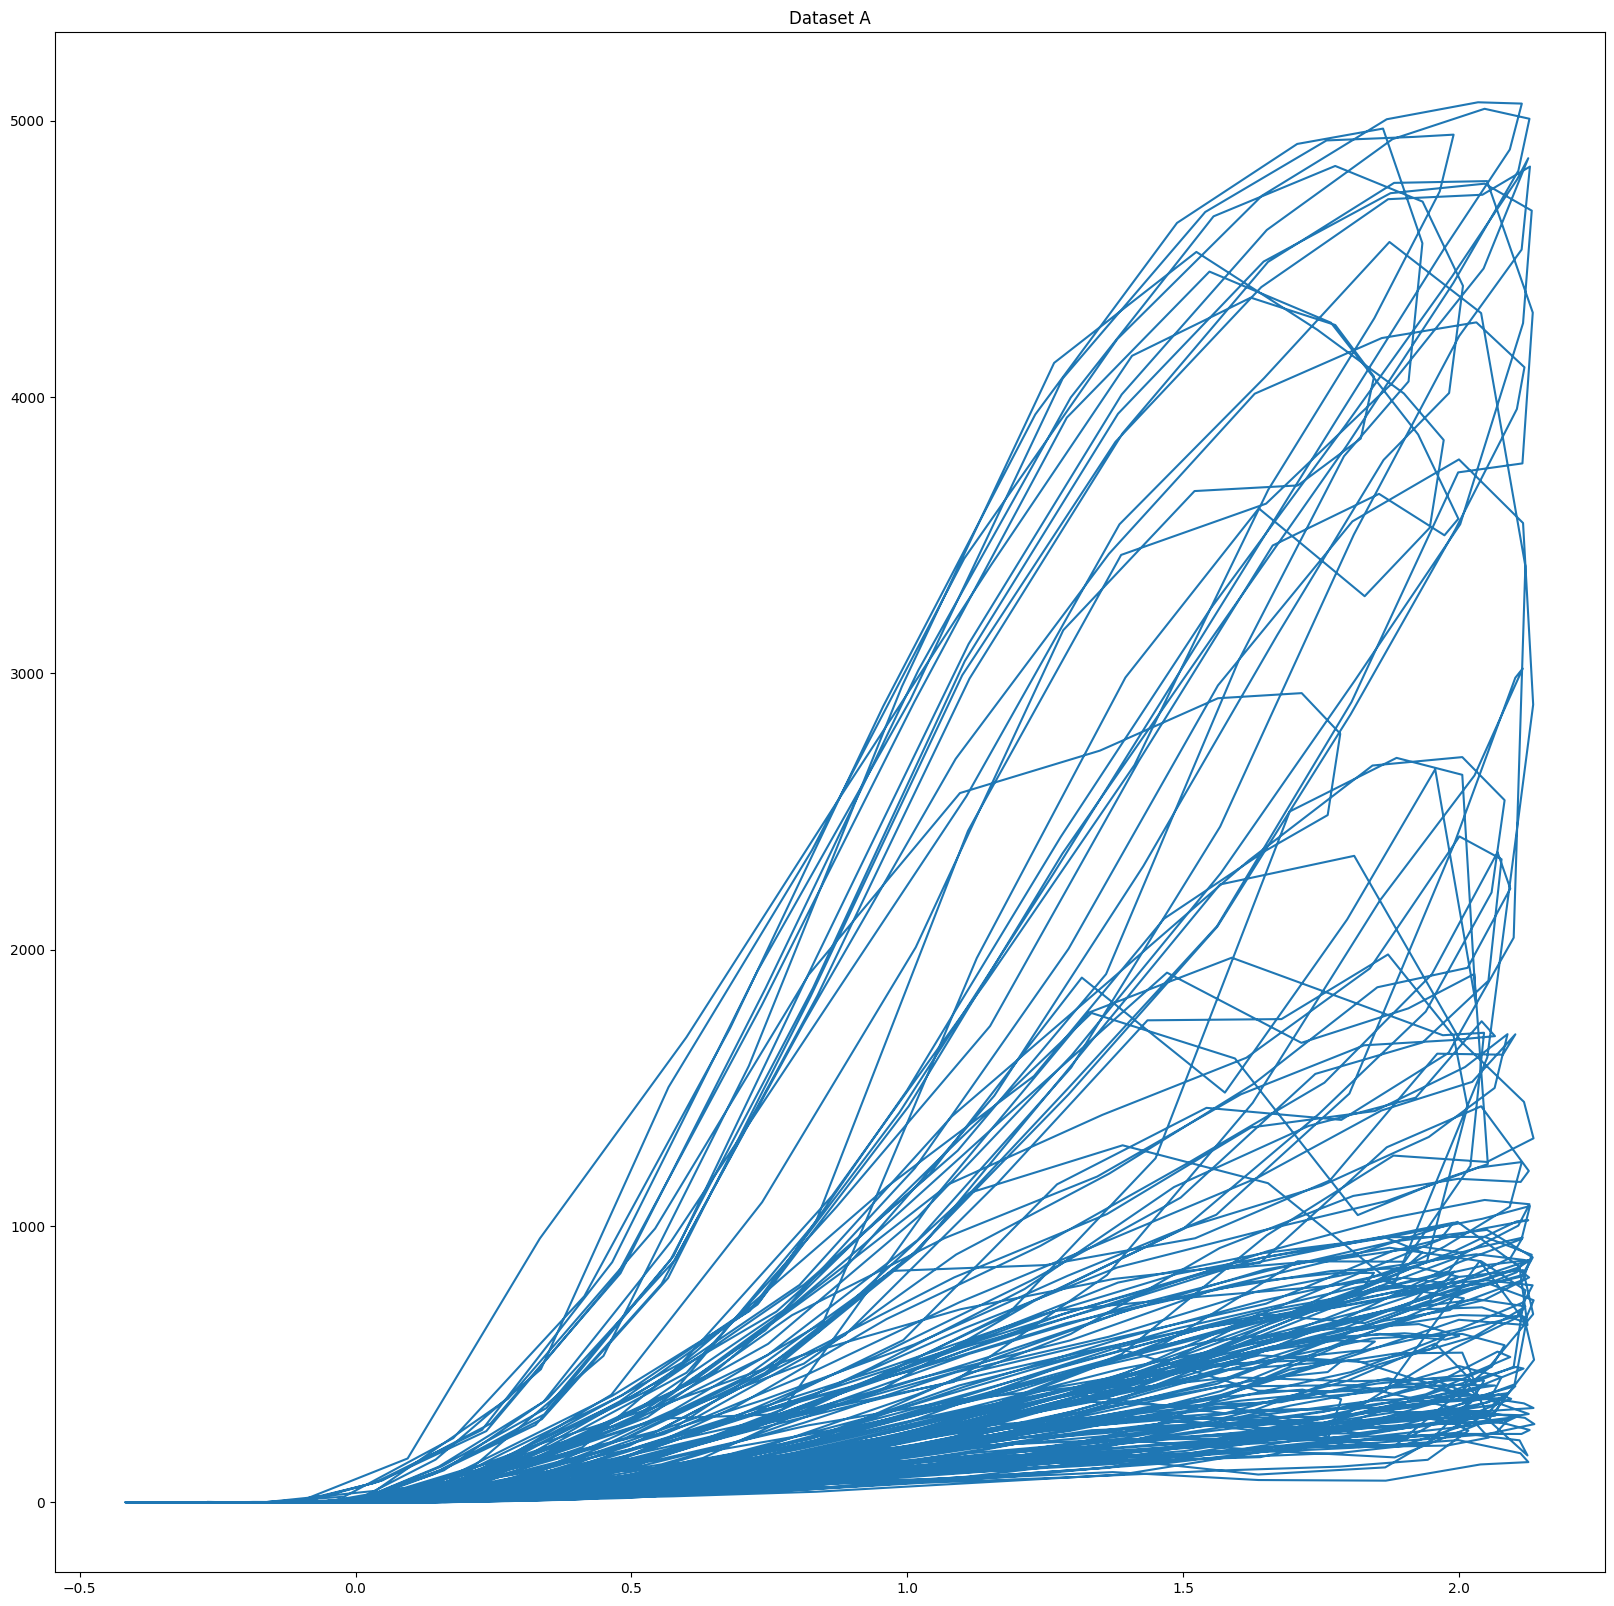

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)
axs.plot(X_test['sun_elevation:d_00'], X_test['prediction'])
axs.set_title('Dataset A')
plt.show()

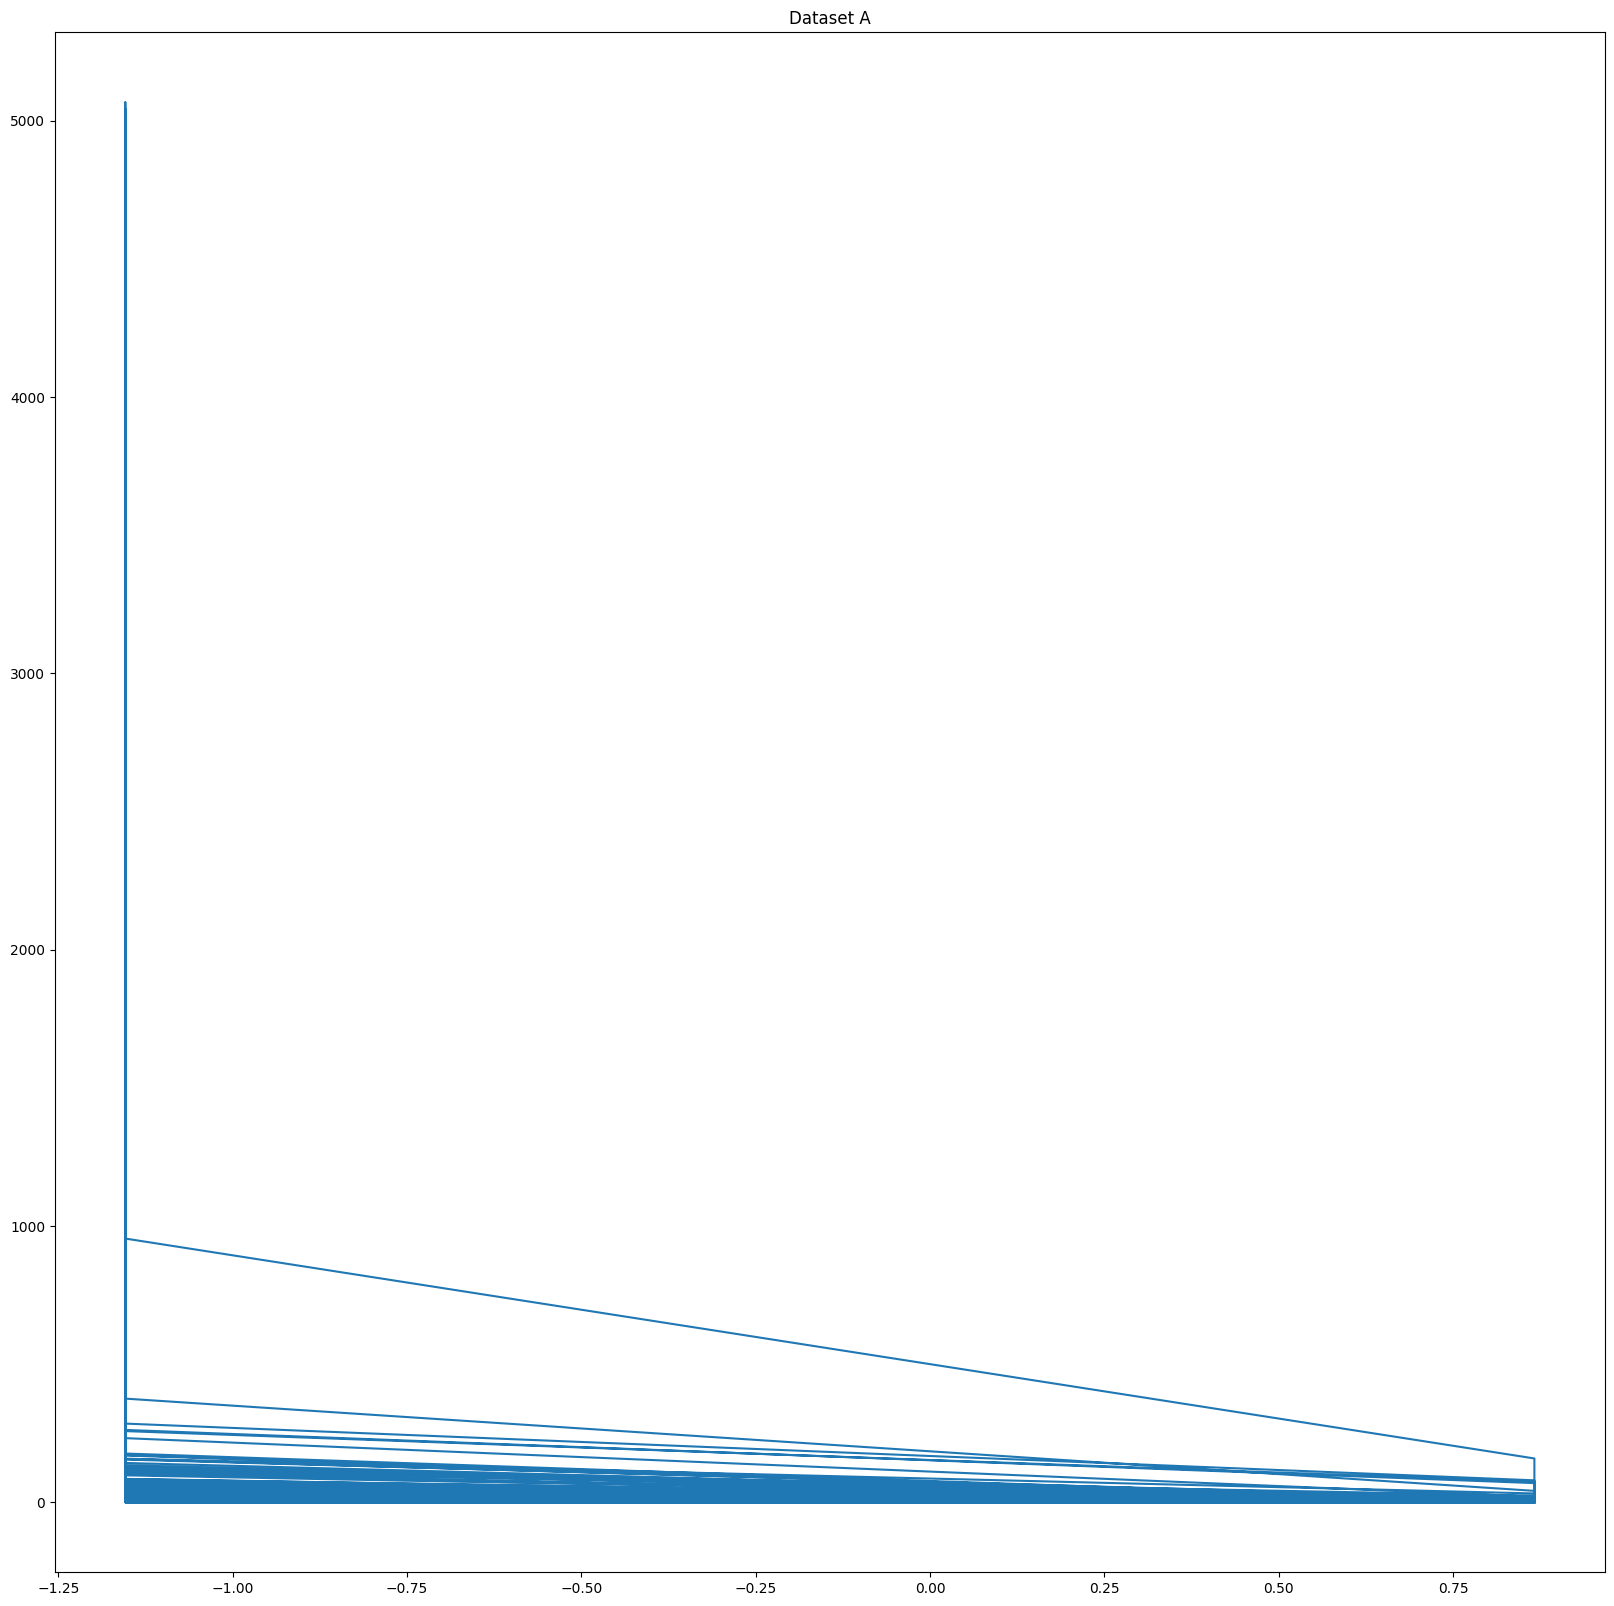

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)
axs.plot(X_test['is_in_shadow:idx_00'], X_test['prediction'])
axs.set_title('Dataset A')
plt.show()

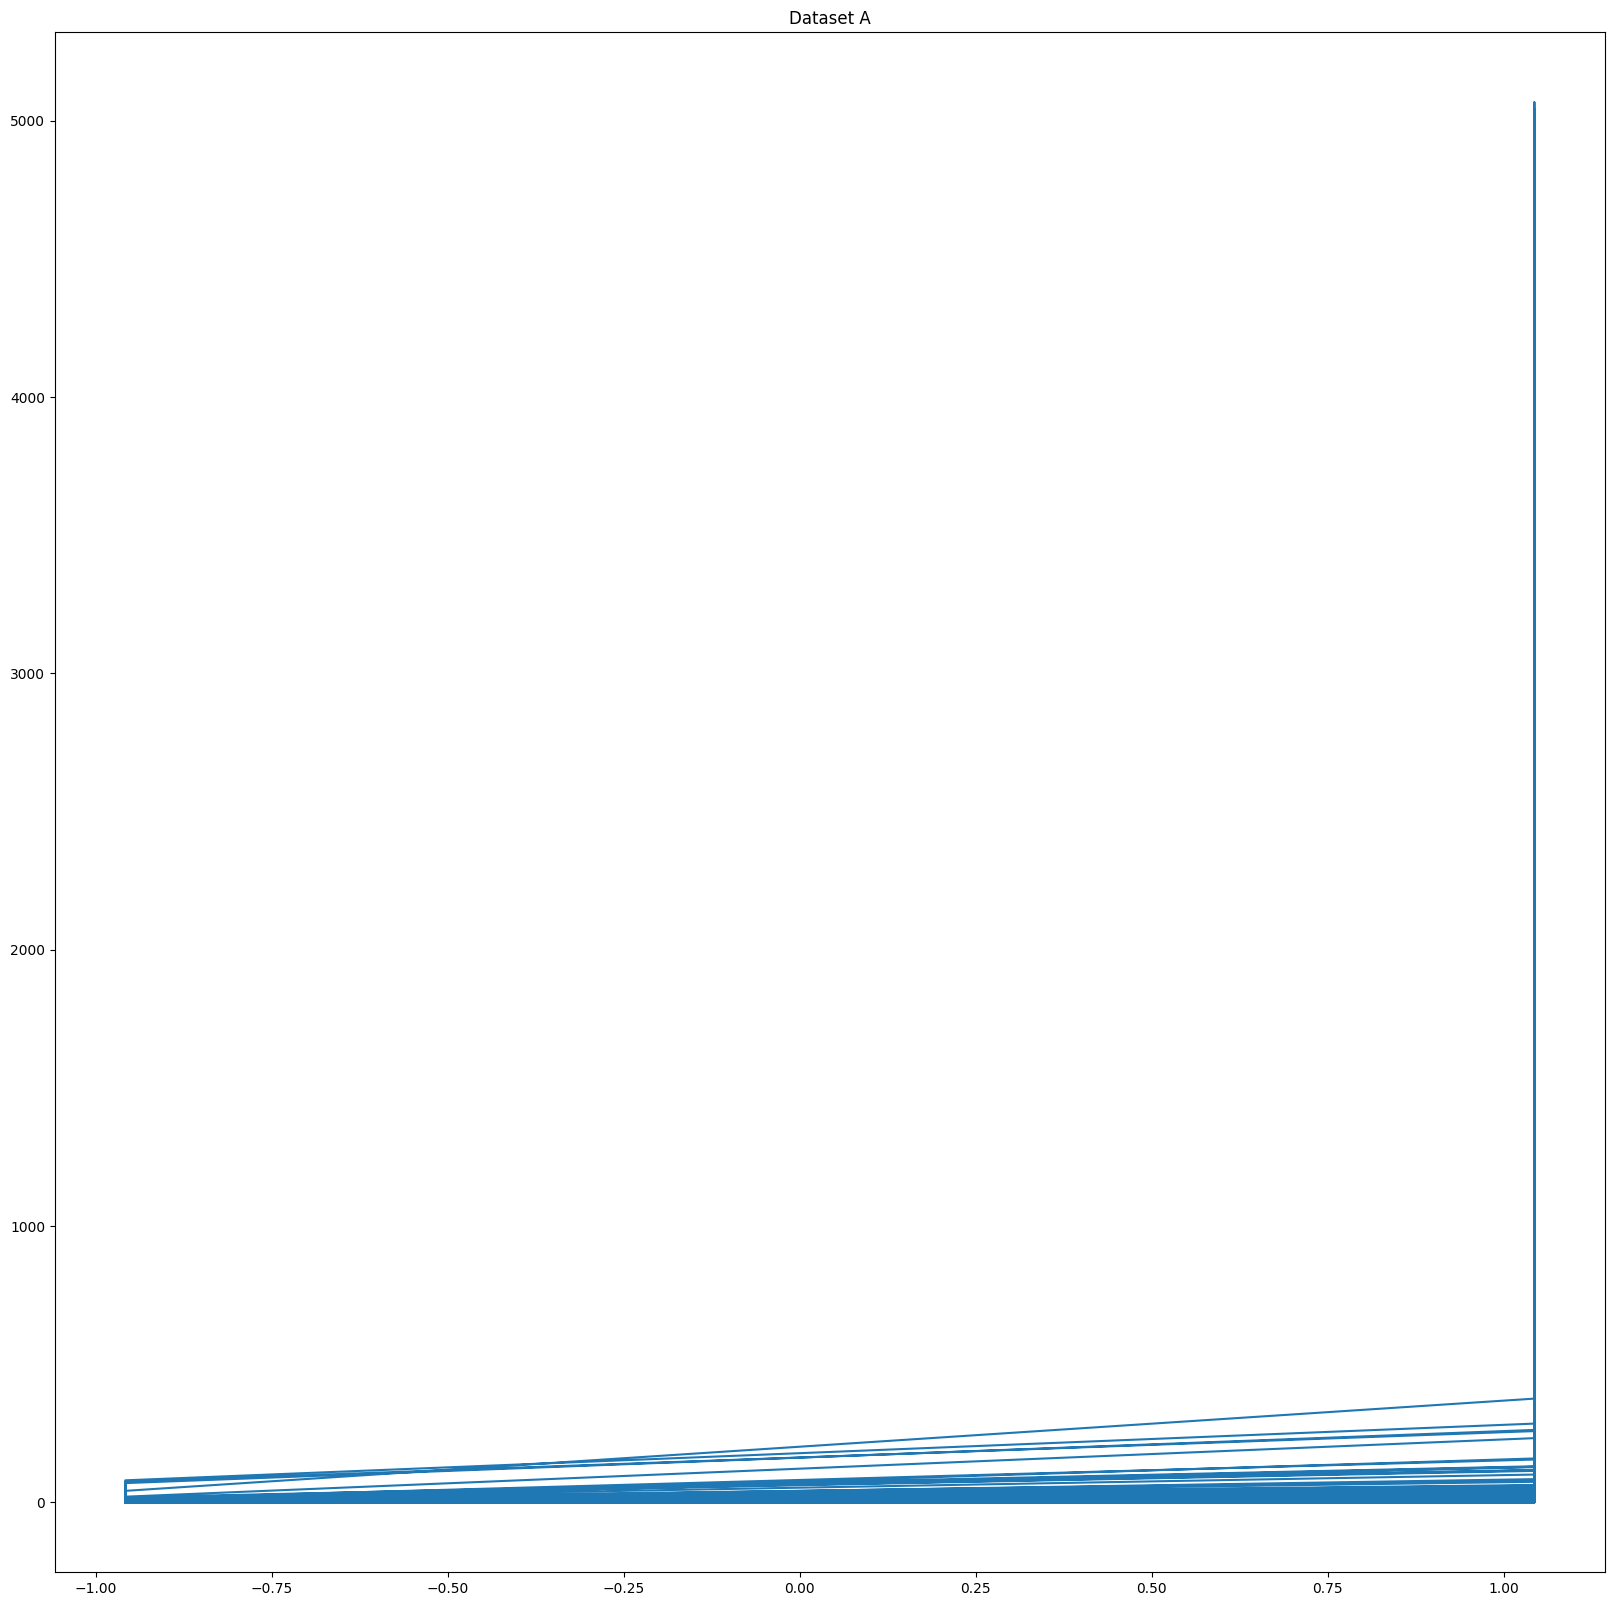

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)
axs.plot(X_test['is_day:idx_00'], X_test['prediction'])
axs.set_title('Dataset A')
plt.show()

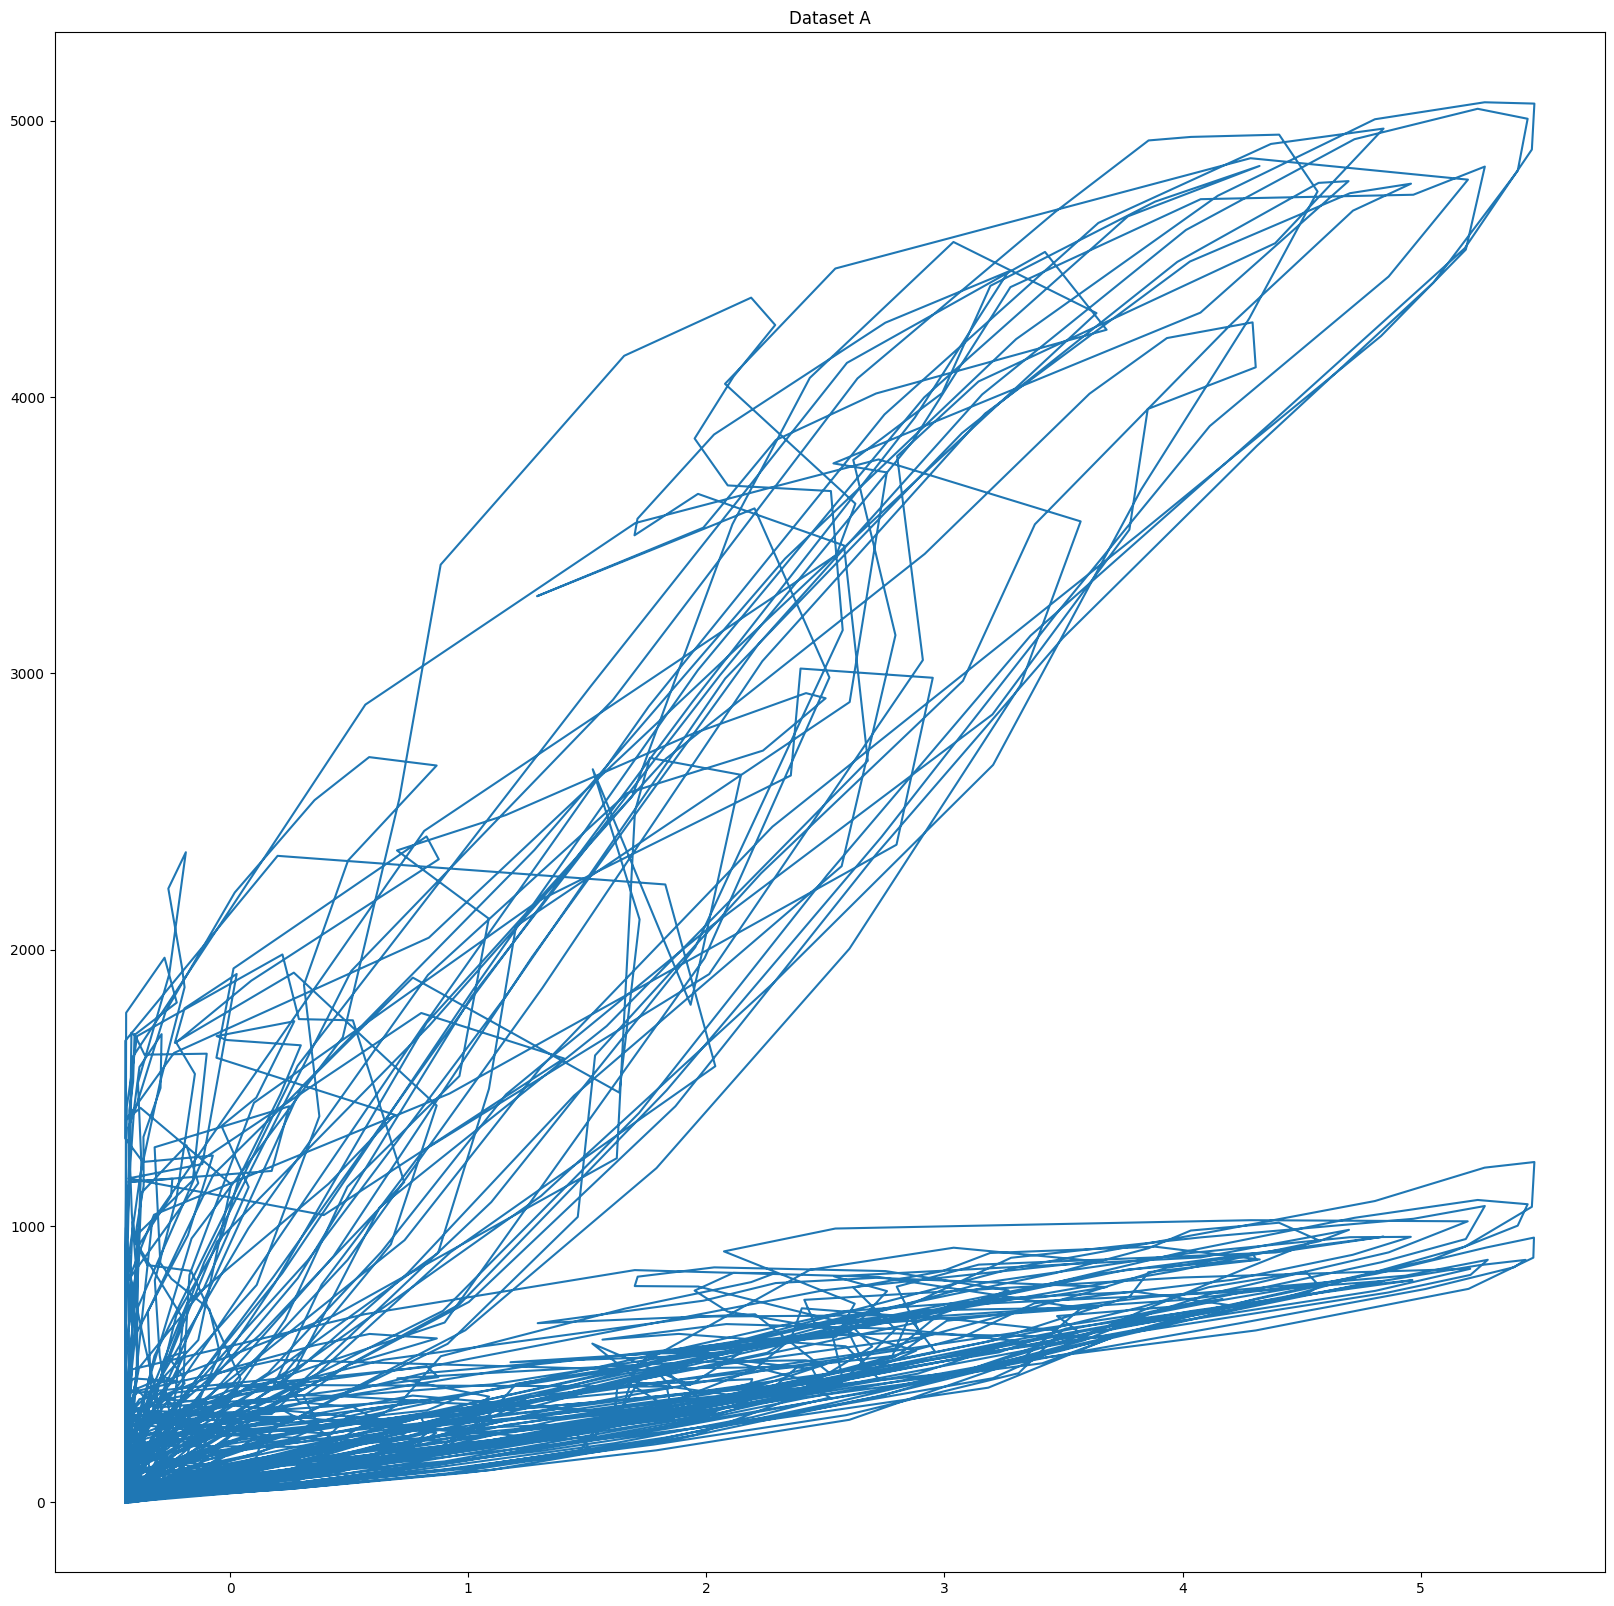

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)
axs.plot(X_test['direct_rad:W_00'], X_test['prediction'])
axs.set_title('Dataset A')
plt.show()

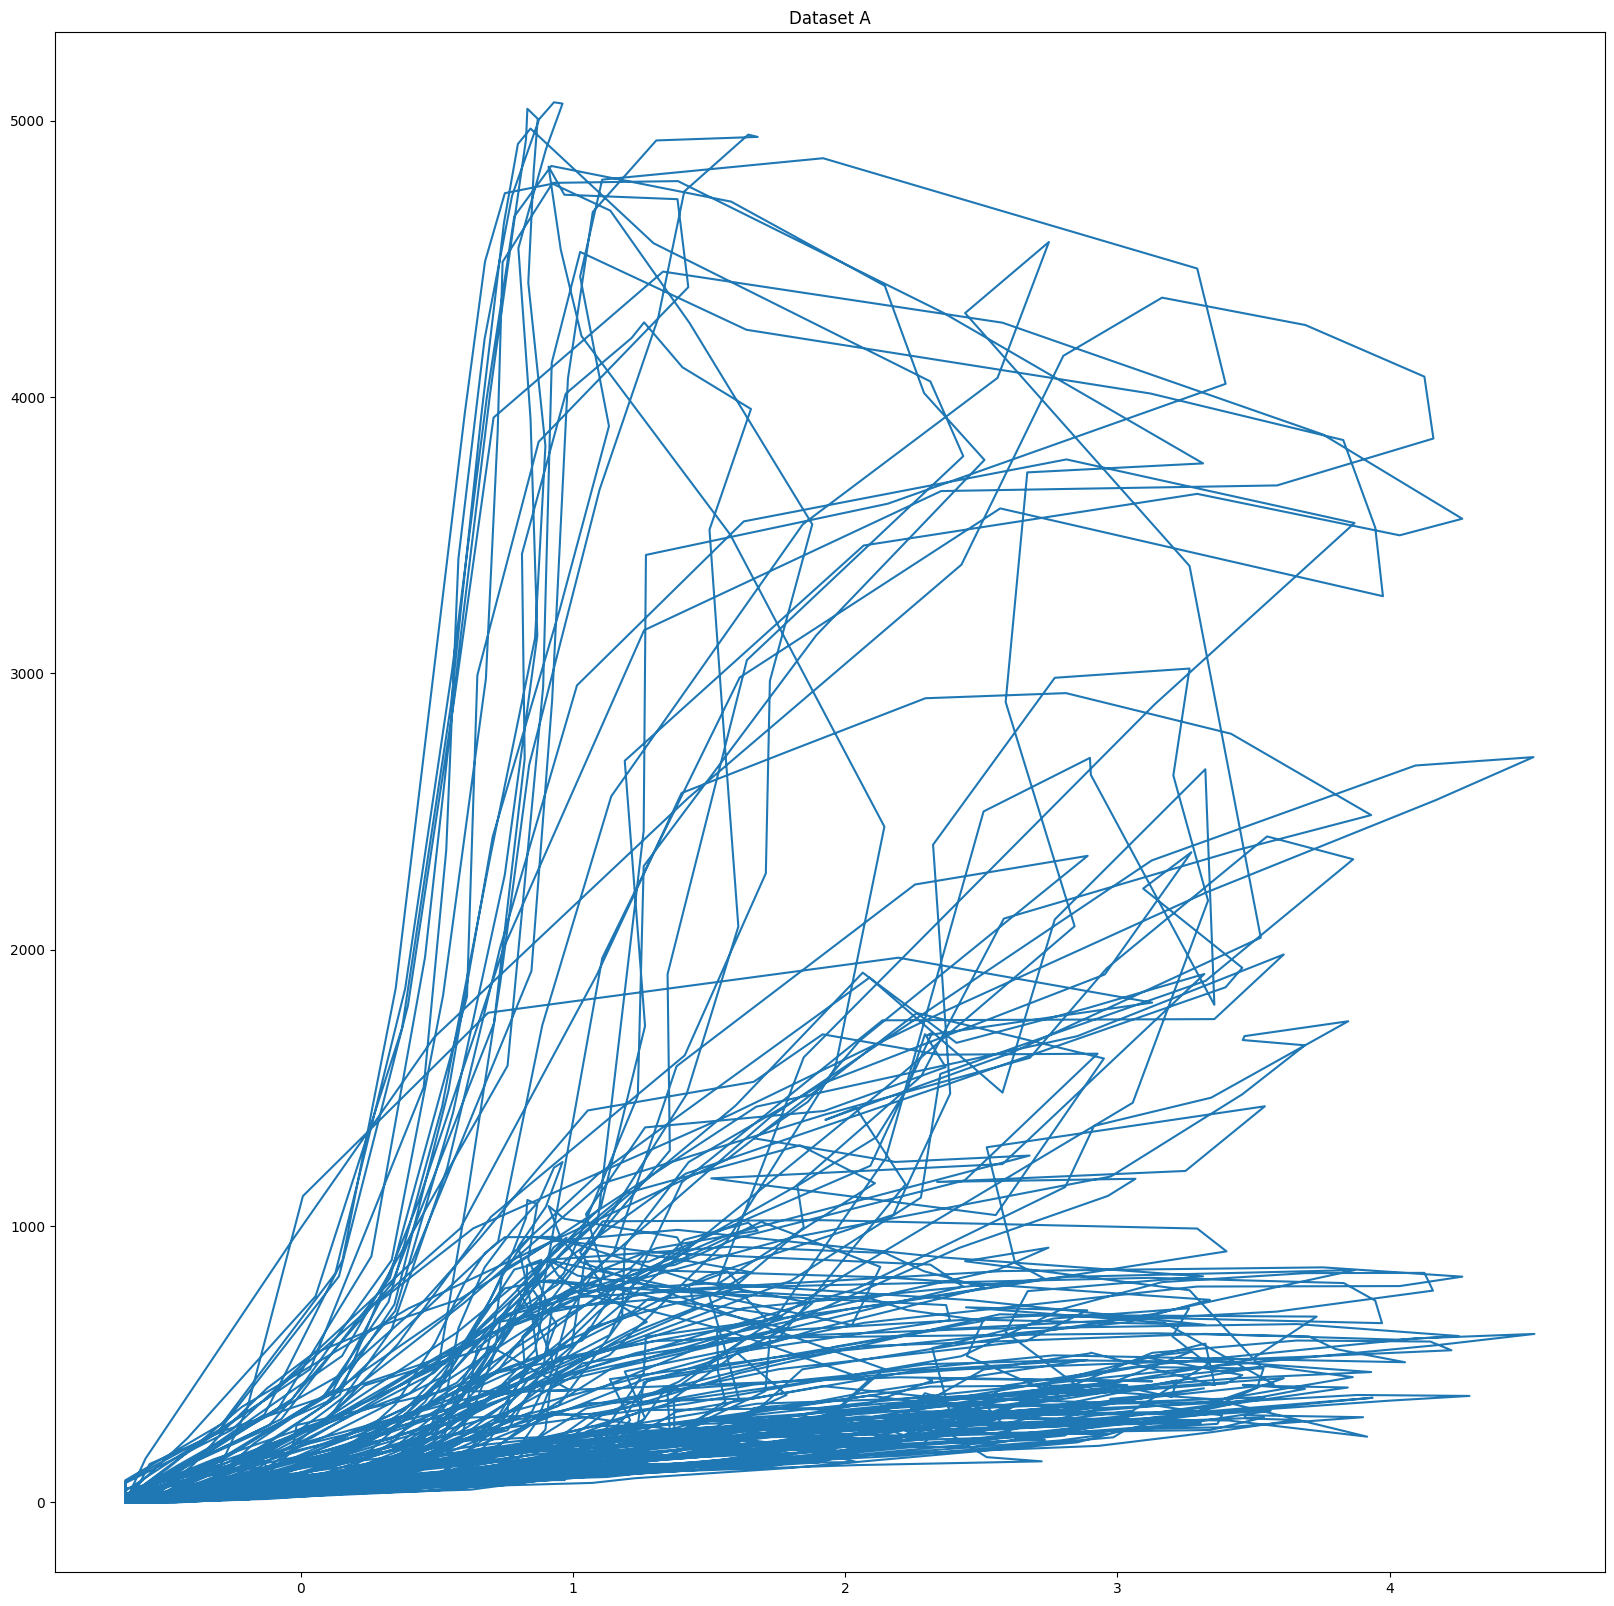

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)
axs.plot(X_test['diffuse_rad:W_00'], X_test['prediction'])
axs.set_title('Dataset A')
plt.show()

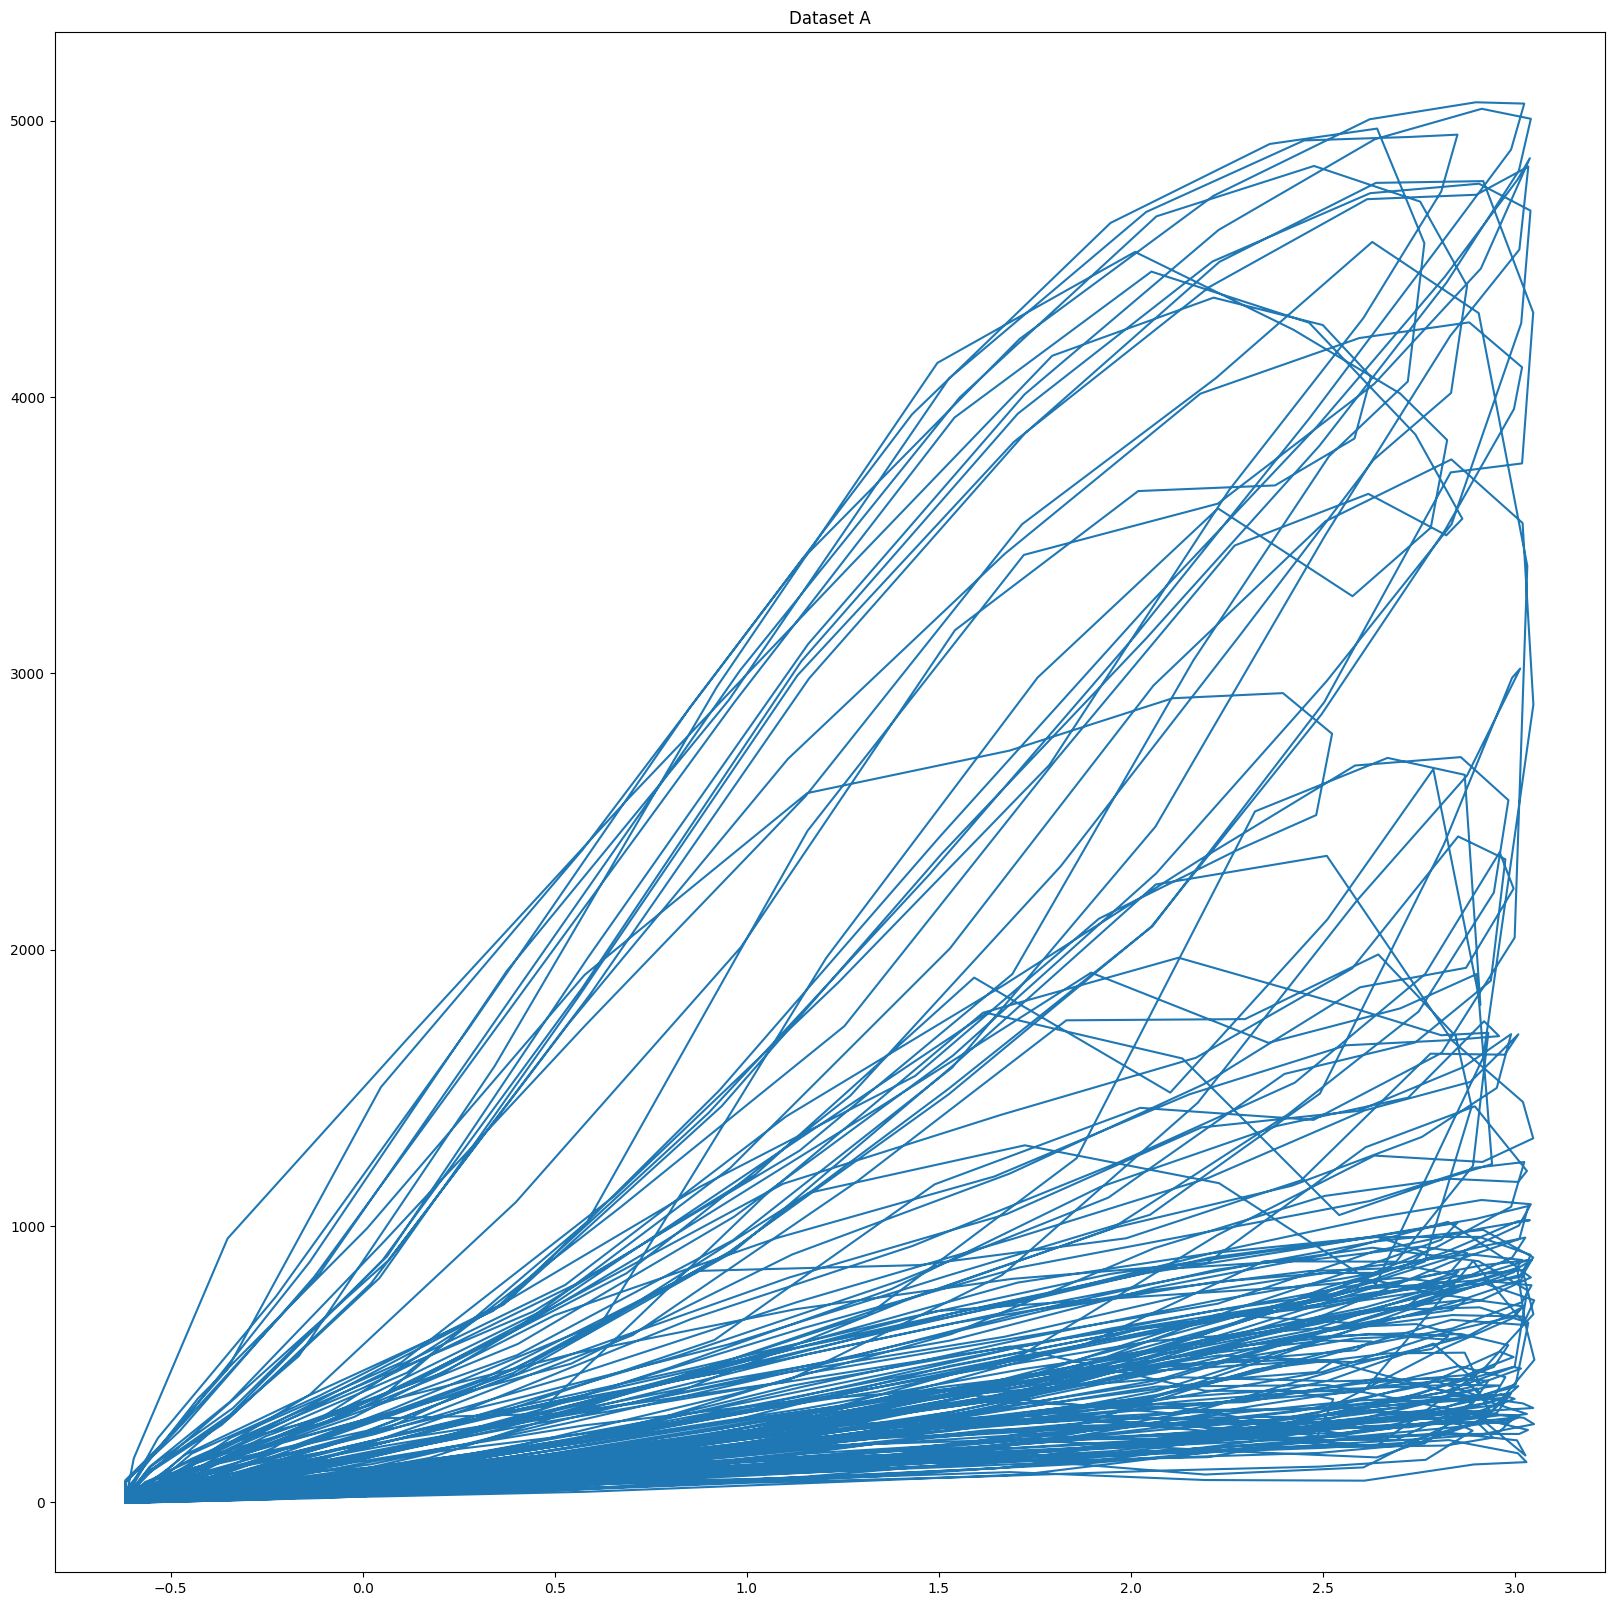

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)
axs.plot(X_test['clear_sky_rad:W_00'], X_test['prediction'])
axs.set_title('Dataset A')
plt.show()